In [1]:
import sys
sys.path.insert(0, '..')

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

from os import listdir
from os.path import join

import deepcoloring as dc

%matplotlib inline
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
basepath = "/media/hpc-4_Raid/vkulikov/Microscopy/Ecoli/ecoli_plus"

rgb = sorted([join(basepath,f) for f in listdir(basepath) if f.endswith('_rgb.png')])
labels = sorted([join(basepath,f) for f in listdir(basepath) if f.endswith('_label.png')])
#Check the names are paired correctly
assert np.array([img[:-7]==lbl[:-9] for img,lbl in zip(rgb,labels)]).all()==True

np.random.seed(1203412412)
indexes = np.random.permutation(len(rgb))
perm_rgb = np.array(rgb)[indexes].tolist()
perm_labels = np.array(labels)[indexes].tolist()

train_data = dc.Reader(perm_rgb[:-10],perm_labels[:-10],2)
valid_data = dc.Reader(perm_rgb[-10:],perm_labels[-10:],2)

In [20]:
transforms = [dc.clip_patch((256, 256)),
              dc.flip_horizontally(),
              dc.flip_vertically(),
              dc.rotate90(),
              dc.blur(),
              dc.normalize(0.5, 0.5)]

generator = train_data.create_batch_generator(20, transforms=transforms)


def clip_mask_builder(builder,size=256,target=132):
    padding_shift = (size - target) / 2
    def f(y):
        return builder(y[:,padding_shift:padding_shift+target,padding_shift:padding_shift+target])
    return f

mask_builder = clip_mask_builder(dc.build_halo_mask(fixed_depth=100))

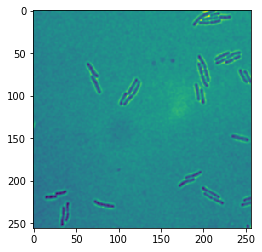

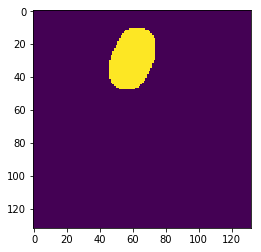

In [24]:
plt.imshow(x[0,0])
plt.figure()
plt.imshow(w2[0,4])

In [ ]:
net = dc.EUnet(3, 6, 4, 1, 1, depth=4, padding=0, use_dropout=True).to(device)
net = net.load_state_dict(torch.load("model.t7"))